## Part_1 : Amazon Scraping

#### Importing Libraries

In [191]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
# Function to start the WebDriver
def start_driver():
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(options=options)
    return driver


In [193]:
# Function to scrape data
def scrape_data(driver, products):
    data = []
    for idx, product in enumerate(products):
        try:
            
            if not product.find_elements(By.XPATH, ".//span[text()='Sponsored']"):
                continue

            print(f"✅ Sponsored product #{idx+1}")

            
            try:
                title = product.find_element(By.XPATH, ".//h2/a/span").text.strip()
            except:
                title = "No Title"

            
            try:
                brand = product.find_element(By.XPATH, ".//span[contains(@class, 'a-size-base-plus') and contains(@class, 'a-color-base')]").text.strip()
            except:
                try:
                    brand = product.find_element(By.XPATH, ".//h5/span").text.strip()
                except:
                    brand = "No Brand"

            
            try:
                rating = product.find_element(By.XPATH, ".//span[@class='a-icon-alt']").get_attribute("innerHTML").split()[0]
            except:
                rating = "0"

            
            try:
                reviews = product.find_element(By.XPATH, ".//span[@class='a-size-base s-underline-text']").get_attribute("innerHTML").replace(",", "")
            except:
                reviews = "0"

            
            try:
                price = product.find_element(By.XPATH, ".//span[@class='a-price']//span[@class='a-price-whole']").get_attribute("innerHTML").replace(",", "")
            except:
                price = "No Price"

            
            try:
                image_url = product.find_element(By.TAG_NAME, "img").get_attribute("src")
            except:
                image_url = "No Image"

            
            try:
                product_url = product.find_element(By.TAG_NAME, "a").get_attribute("href")
            except:
                product_url = "No URL"

            # Append the data
            data.append([title, brand, reviews, rating, price, image_url, product_url])

        except Exception as e:
            print(f"Error on product #{idx+1}: {e}")
            continue
    return data

In [194]:
# Reverting to the previous state where the rating function was working
retry_limit = 3
retry_count = 0
data = []  

while retry_count < retry_limit:
    try:
        driver = start_driver()

        
        driver.get('https://www.amazon.in/s?k=soft+toys')

        
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.XPATH, ".//div[@data-component-type='s-search-result']"))
        )

        
        products = driver.find_elements(By.XPATH, ".//div[@data-component-type='s-search-result']")
        
        
        print(f"Found {len(products)} products.")

        if len(products) == 0:
            print("No products found, check the XPath and page URL.")
            driver.quit()
            break
        
        
        for idx, product in enumerate(products):
            try:
                
                if not product.find_elements(By.XPATH, ".//span[text()='Sponsored']"):
                    continue

                # Title 
                try:
                    title = product.find_element(By.CSS_SELECTOR, "h2 a span").text.strip()
                    if not title:
                        raise ValueError("Empty title text")
                except:
                    try:
                        title = product.find_element(By.XPATH, ".//span[contains(@class, 'a-text-normal')]").text.strip()
                    except:
                        try:
                            title = product.find_element(By.TAG_NAME, "img").get_attribute("alt").strip()
                        except:
                            title = "No Title"

                # Clean unwanted prefixes
                if title.startswith("Sponsored Ad - "):
                    title = title.replace("Sponsored Ad - ", "", 1).strip()



                # Brand
                try:
                    brand = product.find_element(By.XPATH, ".//div[contains(@class,'a-row a-size-base a-color-secondary')]/span[1]").text.strip()
                    if brand.lower() == "visit the":
                        
                        brand = product.find_element(By.XPATH, ".//div[contains(@class,'a-row a-size-base a-color-secondary')]/span[2]").text.strip()
                except:
                    
                    brand = title.split()[0] if title != "No Title" else "No Brand"
                   

                
                try:
                    rating = product.find_element(By.XPATH, ".//span[@class='a-icon-alt']").get_attribute("innerHTML").split()[0]
                except:
                    rating = "0"

                
                try:
                    reviews = product.find_element(By.XPATH, ".//span[@class='a-size-base s-underline-text']").get_attribute("innerHTML").replace(",", "")
                except:
                    reviews = "0"

                
                try:
                    price = product.find_element(By.XPATH, ".//span[@class='a-price']//span[@class='a-price-whole']").get_attribute("innerHTML").replace(",", "")
                except:
                    price = "No Price"

                
                try:
                    image_url = product.find_element(By.TAG_NAME, "img").get_attribute("src")
                except:
                    image_url = "No Image"

                
                try:
                    product_url = product.find_element(By.TAG_NAME, "a").get_attribute("href")
                except:
                    product_url = "No URL"

                
                data.append([title, brand, reviews, rating, price, image_url, product_url])

            except Exception as e:
                print(f"Error on product #{idx+1}: {e}")
                continue

        
        driver.quit()  
        break
    except Exception as e:
        print(f"Error occurred: {e}. Retrying...")
        retry_count += 1
        if 'driver' in locals():
            driver.quit()
        time.sleep(2)  

if data:
    df = pd.DataFrame(data, columns=[
        'Title', 'Brand', 'Reviews', 'Rating', 'Selling Price', 'Image URL', 'Product URL'
    ])
    df.to_csv("sponsored_soft_toys.csv", index=False)
    print(f"Data saved to sponsored_soft_toys.csv with {len(df)} entries.")
else:
    print("No sponsored products found.")

Found 60 products.
Data saved to sponsored_soft_toys.csv with 12 entries.


In [195]:


# Load the raw CSV
df = pd.read_csv("sponsored_soft_toys.csv")

# --- Part 1: Basic cleaning ---

# Remove duplicates
df.drop_duplicates(inplace=True)

# Replace placeholder values
df['Selling Price'] = df['Selling Price'].replace('No Price', pd.NA)
df['Reviews'] = df['Reviews'].replace('0', pd.NA)
df['Rating'] = df['Rating'].replace('0', pd.NA)
df['Brand'] = df['Brand'].replace('No Brand', pd.NA)
df['Title'] = df['Title'].replace('No Title', pd.NA)

# --- Part 2: Convert data types ---

# Convert Selling Price to numeric
df['Selling Price'] = df['Selling Price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['Selling Price'] = pd.to_numeric(df['Selling Price'], errors='coerce')

# Convert Reviews to numeric
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Convert Rating to numeric (e.g., "4.3 out of 5 stars" -> 4.3)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# --- Part 3: Drop rows with missing essential data ---
# Only drop rows where Selling Price is missing (keep others for now)
df = df[df['Selling Price'].notna()]

# Optional: Reset index
df.reset_index(drop=True, inplace=True)

# Save cleaned data
df.to_csv("cleaned_sponsored_soft_toys.csv", index=False)
print(f"✅ Cleaned data saved with {len(df)} rows.")


✅ Cleaned data saved with 12 rows.


In [196]:
# Ensure proper data types
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df['Selling Price'] = pd.to_numeric(df['Selling Price'], errors='coerce')

/tmp/ipykernel_193405/2043111377.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_counts.values, y=brand_counts.index, palette="viridis")


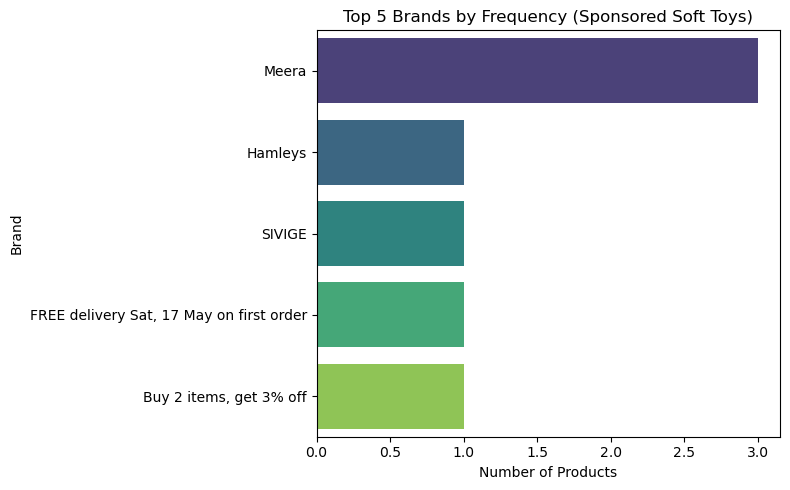

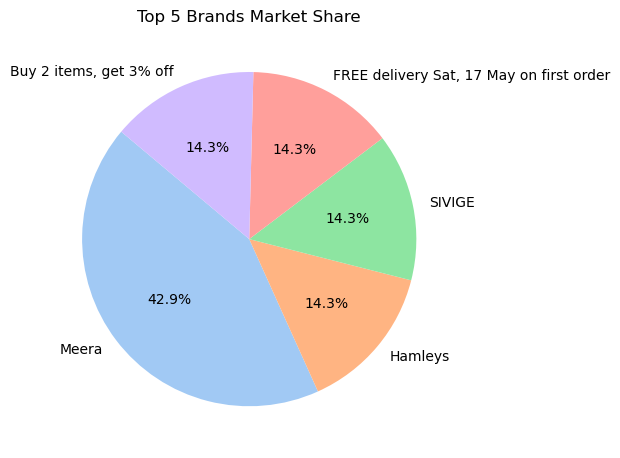


📈 Average Rating by Brand:
 Brand
Meera    2.0
Name: Rating, dtype: float64


In [197]:
# --- 1. Brand Performance Analysis ---

# Top 5 brands by frequency
brand_counts = df['Brand'].value_counts().head(5)
plt.figure(figsize=(8, 5))
sns.barplot(x=brand_counts.values, y=brand_counts.index, palette="viridis")
plt.title("Top 5 Brands by Frequency (Sponsored Soft Toys)")
plt.xlabel("Number of Products")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

# Pie chart of top brand share
plt.figure(figsize=(6, 6))
plt.pie(brand_counts.values, labels=brand_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Top 5 Brands Market Share")
plt.tight_layout()
plt.show()

# Average rating by brand (only brands with more than 2 entries)
brand_rating_avg = df.groupby('Brand')['Rating'].mean().sort_values(ascending=False)
brand_rating_avg_filtered = brand_rating_avg[df['Brand'].value_counts() > 2].head(10)
print("\n📈 Average Rating by Brand:\n", brand_rating_avg_filtered)

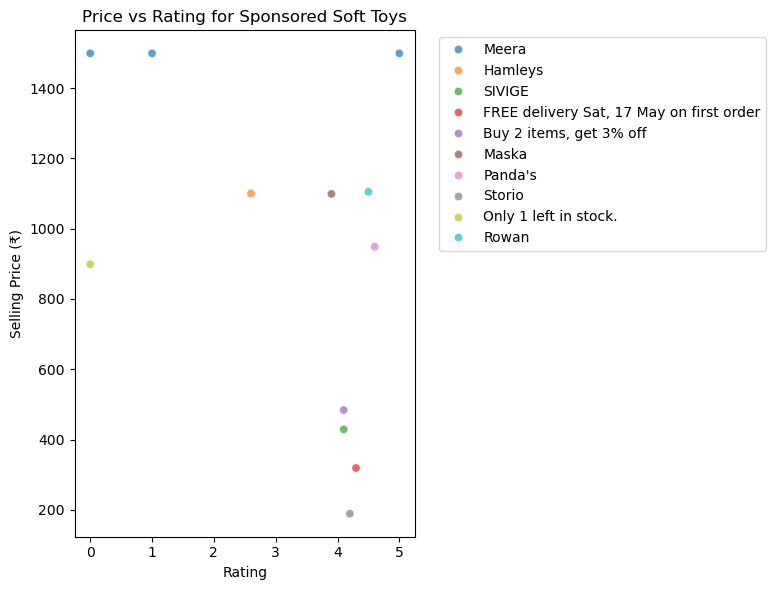

/tmp/ipykernel_193405/1154174703.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_rating = df.groupby('Rating Bucket')['Selling Price'].mean()
/tmp/ipykernel_193405/1154174703.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_rating.index, y=avg_price_by_rating.values, palette="coolwarm")


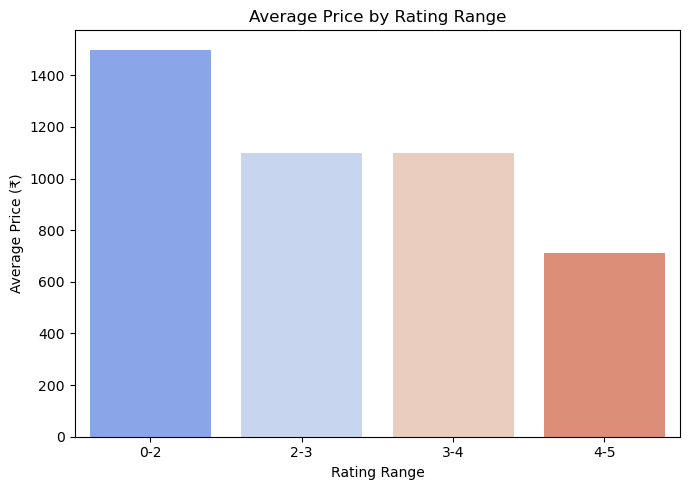

In [198]:
# --- 2. Price vs Rating Analysis ---

# Scatter plot: Price vs Rating
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Rating', y='Selling Price', hue='Brand', alpha=0.7)
plt.title("Price vs Rating for Sponsored Soft Toys")
plt.xlabel("Rating")
plt.ylabel("Selling Price (₹)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Bar chart: Avg price by rating range
df['Rating Bucket'] = pd.cut(df['Rating'], bins=[0, 2, 3, 4, 5], labels=["0-2", "2-3", "3-4", "4-5"])
avg_price_by_rating = df.groupby('Rating Bucket')['Selling Price'].mean()
plt.figure(figsize=(7, 5))
sns.barplot(x=avg_price_by_rating.index, y=avg_price_by_rating.values, palette="coolwarm")
plt.title("Average Price by Rating Range")
plt.xlabel("Rating Range")
plt.ylabel("Average Price (₹)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_193405/3692811575.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviewed['Reviews'], y=top_reviewed['Title'], palette="magma")


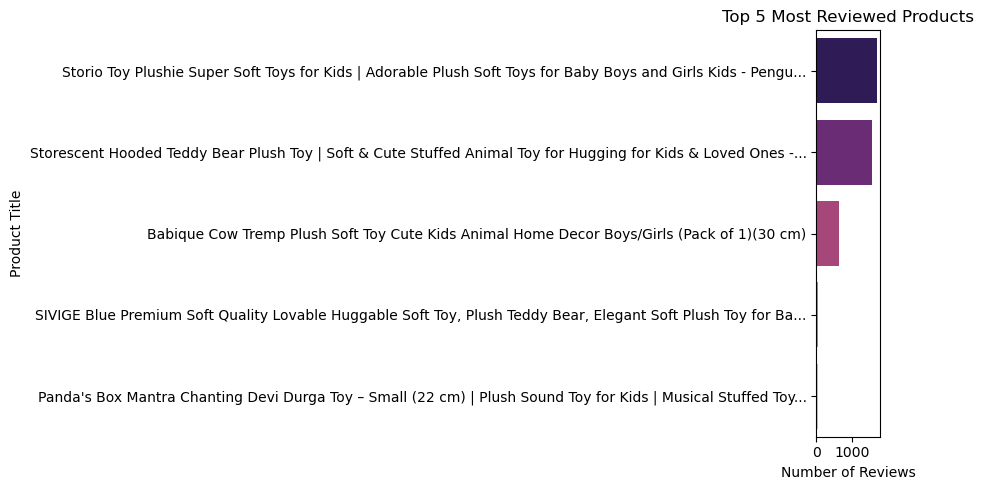

/tmp/ipykernel_193405/3692811575.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated['Rating'], y=top_rated['Title'], palette="summer")


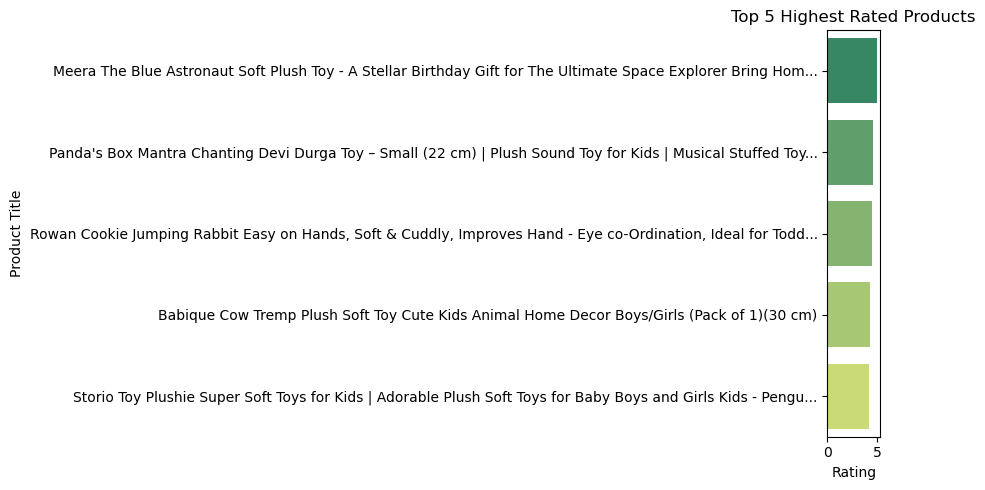

In [199]:
# --- 3. Review & Rating Distribution ---

# Top 5 by reviews
top_reviewed = df.sort_values(by='Reviews', ascending=False).head(5)
plt.figure(figsize=(9, 5))
sns.barplot(x=top_reviewed['Reviews'], y=top_reviewed['Title'], palette="magma")
plt.title("Top 5 Most Reviewed Products")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Title")
plt.tight_layout()
plt.show()

# Top 5 by rating
top_rated = df[df['Rating'] >= 4].sort_values(by='Rating', ascending=False).head(5)
plt.figure(figsize=(9, 5))
sns.barplot(x=top_rated['Rating'], y=top_rated['Title'], palette="summer")
plt.title("Top 5 Highest Rated Products")
plt.xlabel("Rating")
plt.ylabel("Product Title")
plt.tight_layout()
plt.show()